In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import pretrainedmodels
import torch.utils.data as data
import os
import pandas as pd
import torchvision.transforms as transforms
import PIL.Image as Image

In [6]:
data_root = './data/'
data_tag = pd.read_csv('./data/ClsName2id.txt',sep=':',header=None,index_col=0)
size = (512,512)
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5

### 以下为数据读取部分

In [7]:
#调用方式：img_sample = make_sample('./data/train/',tag)
def make_sample(data_root,data_tag,data_type = 'train'):
    img = []
    if data_type != 'test':
        data_dir = os.listdir(data_root)
        for i in data_dir:
            img_name = os.listdir(os.path.join(data_root,i))
            for j in img_name:
                img.append([os.path.join(data_root,i,j),data_tag.loc[i][2]])
    else:
        img_name = os.listdir(data_root)
        for i in img_name:
            img.append(os.path.join(data_root,i))
    return img

In [8]:
class myDatasets(data.Dataset):
    def __init__(self,data_root,data_tag,data_type = 'train'):
        self.data_type = data_type
        if data_type != 'test':
            self.sample = make_sample(data_root,data_tag)
            self.transform = transforms.ToTensor() if data_type == 'val' else transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(),
                transforms.RandomResizedCrop(size,scale = (0.75,1), ratio = (1.0,1.0),interpolation = 2),
                #transforms.RandomCrop((300,400),padding = (84,112),padding_mode = 'reflect'),
                transforms.ToTensor()
            ])
        else:
            self.sample = make_sample(data_root,None,'test')
            self.transform = transforms.ToTensor()
    
    def __getitem__(self,idx):
        img_path = self.sample[idx]
        if self.data_type == 'test':
            img = Image.open(img_path).convert('RGB').resize(size,Image.ANTIALIAS)
            return self.transform(img),img_path[-9:]
        else:
            img = Image.open(img_path[0]).convert('RGB').resize(size,Image.ANTIALIAS)
            return self.transform(img),torch.tensor(img_path[1]-1)
    
    def __len__(self):
        return len(self.sample)

In [9]:
def createDatasets(data_root,data_tag):
    test_path = os.path.join(data_root,'test')
    val_path = os.path.join(data_root,'val')
    train_path = os.path.join(data_root,'train')
    return myDatasets(train_path,data_tag),myDatasets(val_path,data_tag,'val'),myDatasets(test_path,None,'test')

In [10]:
#共177409张训练图片，19712张验证图片，89233测试图片
trainSet,valSet,testSet = createDatasets(data_root,data_tag)
trainloader = data.DataLoader(trainSet,batch_size,shuffle=True)
valloader = data.DataLoader(valSet,batch_size,shuffle=False)
testloader = data.DataLoader(testSet,batch_size,shuffle = False)

In [14]:
a = next(iter(trainloader))

In [19]:
torch.zeros(16,45).shape

torch.Size([16, 45])

### 以下为模型/损失/优化器定义

In [63]:
#模型
model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.last_linear = nn.Linear(2048,45,bias=True)
model = model.to(device)

In [10]:
optimzer = torch.optim.Adam(model.parameters(),lr = 0.001)
loss = nn.CrossEntropyLoss()

### 以下为训练/测试函数定义部分

In [11]:
def train(trainloader,model,loss,optimzer):
    model.train()
    total_loss = 0
    for img,lab in trainloader:
        img = img.to(device)
        lab = lab.to(device)
        pred = model(img)
        l = loss(pred,lab)
        total_loss += l
        optimzer.zero_grad()
        l.backward()
        optimzer.step()
    return total_loss/177409

In [12]:
def val(valloader,model,loss):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for img,lab in valloader:
            img = img.to(device)
            lab = lab.to(device)
            pred = model(img)
            l = loss(pred,lab)
            total_loss += l
    return total_loss/19712

In [13]:
def test(testloader,model,write = True):
    model.eval()
    submission = pd.DataFrame(columns=['lab'])
    with torch.no_grad():
        for img,name in testloader:
            img = img.to(device)
            pred = model(img).argmax(dim=1)+1
            pred = pred.cpu().tolist()
            for i,j in zip(img,pred):
                submission.loc[i] = j
    if write:
        submission.to_csv('submission.txt',sep=' ',header=None)

### 以下为主流程

In [14]:
def main():
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        train_loss.append(train(trainloader,model,loss,optimzer))
        val_loss.append(val(valloader,model,loss))
        print('epoch:{}/{},train_loss{},val_loss{}'.format(epoch+1,epochs,train_loss[epoch],val_loss[epoch]))
    test(testloader,model)

In [ ]:
main()

In [35]:
model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

In [36]:
model.fc = nn.Linear(2048,45,bias=True)

In [48]:
im = torch.FloatTensor(1,3,512,512)

In [49]:
im = torch.FloatTensor(1,3,512,512)
a = model.layer0(im)
a.shape

torch.Size([1, 64, 128, 128])

In [50]:
a = model.layer1(a)
a.shape

torch.Size([1, 256, 128, 128])

In [51]:
a = model.layer2(a)
a.shape

torch.Size([1, 512, 64, 64])

In [52]:
a = model.layer3(a)
a.shape

torch.Size([1, 1024, 32, 32])

In [53]:
a = model.layer4(a)
a.shape

torch.Size([1, 2048, 16, 16])

In [54]:
a = model.avg_pool(a)
a.shape

torch.Size([1, 2048, 10, 10])

In [55]:
a = model.last_linear(a)
a.shape

RuntimeError: size mismatch, m1: [20480 x 10], m2: [2048 x 1000] at c:\a\w\1\s\tmp_conda_3.7_104535\conda\conda-bld\pytorch_1550400486030\work\aten\src\th\generic/THTensorMath.cpp:940

In [12]:
img = Image.open('./data/residential-area_02938.jpg')

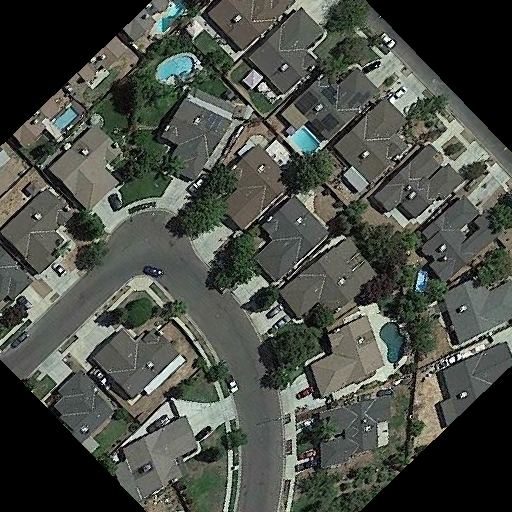

In [40]:
transforms.RandomRotation(45)(img)

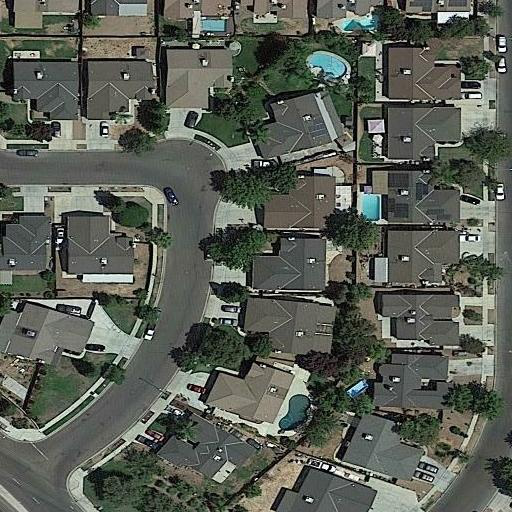

In [30]:
img